# Описание задания

В рамках данного задания, студент должен создать и оценить 4 типа рекомендательных систем:
* Non-personalized RS
* Content-based RS
* Item-based collaborative filtering RS
* Hybrid RS

Каждая рекомендательная система - отдельное подзадание. Подзадание считается выполненным, если студент создал рекомендательную систему, которая **лучше (или хуже, но не более чем на 10%)** системы, созданной автором данного блокнота. Системы оцениваются с использованием метрики ``HR@N``, описанной ниже.

# Детальное описание

#### Данные: 
Датасет представлен множеством отзывов к компьютерным играм (объектам) от пользователей Amazon. Каждый отзыв представлен в виде JSON-структуры со следующими полями:
* идентификатор пользователя - reviewerID
* идентификатор объекта - asin
* текст отзыва - reviewText
* рейтинг - overall
* время публикации обзора - unixReviewTime
* другие поля, не использованные автором этого блокнота (смотри полное описание JSON [тут](http://jmcauley.ucsd.edu/data/amazon/))

У каждого объекта есть как минимум 5 отзывов, каждый пользователь написал как минимум 5 отзывов. 
#### Цель: 
Построить рекомендательную систему, предсказывающую объекты, которые пользователь приобретет в ближайшем будущем. Для упрощения мы считаем, что пользователь приобрел объект, если он написал про него отзыв.
#### Подготовка данных:
Данные разделены на тренировочную и тестовую выборки по времени публикации отзывов. Первые 80% данных (более старые) используются как тренировочная выборка, остальные - как тестовая. 

Построение рекомендательной системы (т.е., выбор и тренировка моделей, оптимизация параметров и т.д.) осуществляется **только** с использованием тренировочной выборки. Все параметры, использованные в моделях, **должны быть** получены или объяснены с помощью тренировочных данных. Студент вправе использовать тренировочную выборку как его душе угодно. 

Тестирующая выборка используется **только** для оценки рекомендательной системы.

Для построения рекомендательных моделей также можно использовать JSON-поля из датасета, неиспользованные автором этого блокнота.
#### Оценка качества рекомендательной системы
Цель рекомендательной системы - посоветовать пользователю объекты, которые он захочет приобрести. Для оценки качества такой системы мы воспользуемся метрикой `hit-ratio (HR)`. 

$$
HR = \frac{1}{|U_T|}\sum_{u \in U_T} \mathrm{I}(Rel_u \cap Rec_u)
$$

* $U_T$ - множество пользователей из тестовой выборки
* $Rec_u$ - множество объектов, рекомендованных пользователю $u$ 
* $Rel_u$ - множество объектов, оцененных пользователем $u$ в тестовой выборке
* $\mathrm{I}(Rel_u \cap Rec_u)$ - бинарная функция-индикатор. Функция возвращает 1 если $Rel_u \cap Rec_u \ne \emptyset$, иначе 0

$HR=1$ если для каждого пользователя мы рекомендовали хотя бы один релевантный объект. Так как обычно пользователи просматривают только первые $N$ рекомендаций, мы будем считать метрику $HR@N$, где $N=10$ (т.е. множество $Rec_u$ будет содержать только 10 объектов). 

# Условные обозначения
* `uid` - идентификатор пользователя
* `iid` - идентификатор объекта

# Games RSs

In [1]:
# импорты, которые точно понадобятся
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "/Users/Slava-N/Progs/DataScience/Homework/5 RecSys/reviews_Video_Games_5.json"
N = 10

In [3]:
!pwd

/Users/Slava-N/Progs/DataScience/Homework/5 RecSys


## Анализ данных

In [4]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt))
        
    return pd.DataFrame(rows, columns=cols)

In [5]:
df = get_data_frame()
df.head(15)

,uid,iid,review,rating,dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400
2,2,0,1st shipment received a book instead of the ga...,1.0,1403913600
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600
5,5,0,"Overall this is a well done racing game, with ...",4.0,1368230400
6,6,0,Loved playing Dirt 2 and I thought the graphic...,5.0,1313280000
7,7,0,I can't tell you what a piece of dog**** this ...,1.0,1353715200
8,8,0,I initially gave this one star because it was ...,4.0,1352851200
9,9,0,I still haven't figured this one out. Did ever...,2.0,1391817600


In [6]:
print("min-max количество объектов на пользователя:", 
      df.groupby("uid").iid.nunique().min(), df.groupby("uid").iid.nunique().max())
print("min-max количество пользователей на объект:", 
      df.groupby("iid").uid.nunique().min(), df.groupby("iid").uid.nunique().max())

min-max количество объектов на пользователя: 5 773
min-max количество пользователей на объект: 5 802


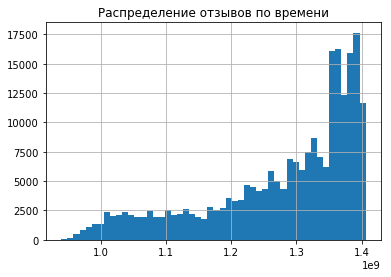

In [7]:
plt.title("Распределение отзывов по времени")
df.dt.hist(bins=50)

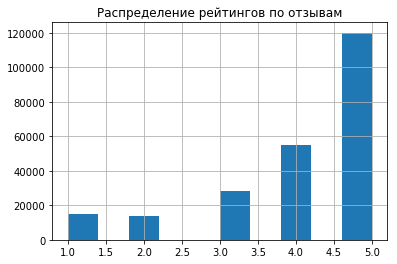

In [8]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist()

In [9]:
# проверяем, есть ли случаи, когда один и тот же пользователь оставляет отзывы на один и тот же объект
df.groupby(["uid", "iid"]).review.count().unique()  # ура, таких случаев нет

array([1])

In [10]:
print("Количество объектов:", df.iid.unique().size)
print("Количество пользователей:", df.uid.unique().size)

Количество объектов: 10672
Количество пользователей: 24303


## Готовим выборки

In [11]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    """
    border_dt = df.dt.quantile(p)
    print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [12]:
training_df, test_df = split_df_by_dt(df)
del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 5) (46353, 5)
Размер после очистки: (185427, 5) (19174, 5)


In [13]:
'*'
def clean_df(df, min_review_per_uid, min_review_per_iid):
    """Функция удаляет из df строки, соответствующие пользователям и объектам, 
    у которых меньше min_review_per_uid и min_review_per_iid отзывов соответственно
    """
    _df = df.copy()
    while True:
        review_per_uid = _df.groupby("uid").review.count()
        bad_uids = review_per_uid[review_per_uid < min_review_per_uid].index
    
        review_per_iid = _df.groupby("iid").review.count()
        bad_iids = review_per_iid[review_per_iid < min_review_per_iid].index
        
        if bad_uids.shape[0] > 0 or bad_iids.shape[0] > 0:
            _df = _df[(~_df.uid.isin(bad_uids)) & (~_df.iid.isin(bad_iids))]
        else:
            break
    return _df

 ## Метрика

Для упрощения тестирования предлагается использовать словарь следующего типа:

```python
recs = {
    uid_1: {
        iid_1: score_11,
        iid_2: score_12,
        ...
    },
    uid_2: {
        iid_1: score_21,
        iid_2: score_22,
        ...
    },
    ...
}
```

где `uid_i` - идентификатор тестового пользователя, `iid_j` - идентификатор рекомендованного объекта, а `score_ij` - предсказанный рейтинг/вес объекта `j` для пользователя `i`.

In [14]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...}
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [15]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict

test_dict = get_test_dict(test_df)

## Non-personalized RS

В первом подзадании студент должен построить неперсонализированную рекомендательную систему. Т.е. рекомендации для одного пользователя строятся на основе отзывов, оставленных всеми пользователями.

Ниже приведены базовые классы для рекомендателей, которые можно использовать при построении собственных моделей.

In [16]:
class BasicRecommender(object):
    def __init__(self):
        pass
    
    def get_recs(self, uid, top):
        """Строит рекомендации для пользователя uid
        :return: словарь типа {iid: score, ...}
        """
        return {}
    
    def get_batch_recs(self, uids, top):
        """Строит рекомендации для нескольких пользователей uids
        :return: словарь типа {uid: {iid: score, ...}, ...}
        """
        return {uid: self.get_recs(uid, top) for uid in uids}
    
class NonPersRecommender(BasicRecommender):
    def __init__(self, df):
        super(NonPersRecommender, self).__init__()
        self.recs = self._prepare_recs(df)
        
    def _prepare_recs(self, df):
        return pd.Series([])
    
    def get_recs(self, uid, top):
        return self.recs[:top].to_dict()
    
    def get_batch_recs(self, uids, top):
        non_pers_recs = self.get_recs(None, top)
        return {uid: non_pers_recs for uid in uids}

Пример неперсональной рекомендательной системы - система, рекомендующая наиболее популярный контент.

In [17]:
class MostReviewedRS(NonPersRecommender):
    def _prepare_recs(self, df):
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        return df.iid.value_counts()  
    
    def _create_recs_dict_for_users(self, df):
        top_10 = self._prepare_recs(df)[:11][:-1]
        top_10_score_dict = { iid: score for iid, score in top_10.iteritems()}
        return { uid : top_10_score_dict for uid in df.uid.unique() }
    


In [18]:
# ищем наиболее рецензируемые (читай - популярные игры) с наивысшим средним рейтингом.
quantile_99_numb_reviews = training_df.iid.value_counts().quantile(0.99)
training_df['number_of_reviews'] = training_df.groupby(['iid'])['rating'].transform('count')
training_df['average_rating'] = training_df.groupby(['iid'])['rating'].transform('mean')
active_reviews_high_rating = training_df[(training_df.number_of_reviews > quantile_99_numb_reviews)]


In [19]:
active_reviews_high_rating.head(10)

,uid,iid,review,rating,dt,number_of_reviews,average_rating
1918,1235,101,"Oh, here they come! Can you hear it? The wimpy...",1.0,1365638400,225.0,4.648889
1919,1236,101,Since this was the first pure Rpg I had ever p...,3.0,1234396800,225.0,4.648889
1920,1237,101,I can't believe how many gamers are hailing th...,4.0,1173830400,225.0,4.648889
1922,1239,101,They really hit the mark on this one!... chara...,5.0,1074211200,225.0,4.648889
1923,391,101,Final Fantasy 7 is a classic. The game is grea...,5.0,1362182400,225.0,4.648889
1924,1240,101,"Wow, the reviews here run the gamut; while I a...",5.0,1084147200,225.0,4.648889
1925,1241,101,I had heard about the FF series but never paid...,4.0,1107043200,225.0,4.648889
1926,1242,101,I love this game. It's probably not the best ...,5.0,1296259200,225.0,4.648889
1927,534,101,"Sephiroth, the main villian of the game, is pr...",5.0,1027900800,225.0,4.648889
1928,1243,101,Final Fantasy 7 is the first Final Fantasy on ...,5.0,995328000,225.0,4.648889


In [20]:
# группировка по iid и сортировка по рейтингам итогового списка
active_reviews_high_rating_top = active_reviews_high_rating[['iid', 'average_rating']].\
            groupby(['iid'])['average_rating'].mean().sort_values(ascending=False)[:10]

In [21]:
active_reviews_high_rating_top

iid
8401    4.896774
3536    4.836676
6053    4.788396
7163    4.782143
1395    4.747706
6492    4.718894
3841    4.688679
3854    4.666667
6814    4.656627
101     4.648889
Name: average_rating, dtype: float64

In [22]:
# формируем словарь рекомендаций
active_reviews_high_rating_top_dict = { iid: score for iid, score in active_reviews_high_rating_top.iteritems()}
active_high_recs = { uid : active_reviews_high_rating_top_dict for uid in training_df.uid.unique() }

In [23]:
# оценка модели (наиболее рецензируемые игры с наивысшим рейтингом) на тестовой выборке - совсем не огонь
hit_ratio(active_high_recs, test_dict)

0.047542186353631694

In [24]:
training_df.dt.min(), training_df.dt.max()

(939859200, 1377129600)

### Считаем игры в тренде с хорошим рейтингом и большим количеством ревью.
###### Смотрим не на максимальное количество ревью, а выше определенного порога.

In [25]:
#определяем границу трендовости игры по времени - 1 января 2012 года (тестовый диапазон с окт 1999 до августа 2013).
timestampt_threshold = 1325376000

training_df.dt.min(), training_df.dt.max()


(939859200, 1377129600)

In [26]:
#определяем ревью, которые выходили только после определнной даты
trending_df = training_df[(training_df.dt.astype(int)) >= timestampt_threshold]
del trending_df['number_of_reviews']
del trending_df['average_rating']



In [27]:
#доставляем количество рейтингов в таблицу к ревью
ratings_per_movie = trending_df.iid.value_counts()

trending_df["nRatings"] = trending_df.apply(lambda x: ratings_per_movie.get(x.iid, 0), axis=1)

/Users/Slava-N/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [28]:
ratings_per_movie.shape

(7911,)

In [29]:
trending_df.shape

(62126, 6)

In [30]:
trending_df.sort_values('nRatings', ascending=False).head(20)

,uid,iid,review,rating,dt,nRatings
186591,15968,8659,Of course it is a great thing to buy it was fo...,5.0,1356566400,361
186445,15693,8659,I bought Halo 4 so I would have a game to play...,3.0,1374364800,361
186447,14015,8659,what can i say? this game is a huge improvemen...,5.0,1356998400,361
186450,20852,8659,If you're looking for a change of pace from CO...,5.0,1352764800,361
186451,17469,8659,The story is NOT immersive.The tactical challe...,1.0,1352332800,361
186452,3069,8659,- GRAPHICS 5/5They are the best on the 360. Wh...,3.0,1352505600,361
186453,15788,8659,"Even thou I like Halo 3 better, this one has b...",5.0,1363996800,361
186454,13766,8659,"I want to love the whole package, I'm a big ha...",4.0,1352678400,361
186455,12098,8659,"This is a great game, if you like shooter and ...",5.0,1367107200,361
186456,7651,8659,"Pretty fun, however i'm more a GoW hardcore fa...",5.0,1363132800,361


In [31]:
average_rating_trending = trending_df[["iid", "rating"]].groupby("iid").rating.mean().sort_values(ascending=False)
trending_df['average_rating'] = trending_df.apply(lambda x: average_rating_trending.get(x.iid, 0), axis=1)


/Users/Slava-N/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
#выбираем только ревью по играм, у которых больше 100 отзывов
trending_reviewed_high_rating = trending_df[trending_df.nRatings > 100]

In [33]:
trending_reviewed_high_rating.sort_values('average_rating', ascending=False)
top_10_trending_reviewed_high_rating = trending_reviewed_high_rating[['iid','average_rating']].\
        groupby("iid").mean().sort_values('average_rating', ascending=False)[:10]

In [34]:
top_10_trending_reviewed_high_rating=pd.Series(top_10_trending_reviewed_high_rating.loc[:,'average_rating'])

In [35]:
top_10_trending_reviewed_high_rating

iid
8401    4.888889
3536    4.864151
7163    4.760870
6492    4.712230
7913    4.696774
9250    4.644231
9267    4.633803
5390    4.632000
8160    4.590164
8208    4.552147
Name: average_rating, dtype: float64

In [36]:
trending_active_reviwed_high_rating_top_dict = { iid: score for iid, score in top_10_trending_reviewed_high_rating.iteritems()}
trending_active_rating_recs = { uid : trending_active_reviwed_high_rating_top_dict for uid in training_df.uid.unique() }

In [37]:
trending_active_reviwed_high_rating_top_dict

{3536: 4.8641509433962264,
 5390: 4.6319999999999855,
 6492: 4.7122302158273461,
 7163: 4.760869565217388,
 7913: 4.6967741935483973,
 8160: 4.5901639344262355,
 8208: 4.5521472392638218,
 8401: 4.8888888888889026,
 9250: 4.6442307692307727,
 9267: 4.633802816901385}

In [38]:
# удалось добиться неплохого результата только комбинацией простых инструментов
hit_ratio(trending_active_rating_recs, test_dict)

0.10403521643433603

Не совсем понимаю, как сделать кросс-валидацию для подбора гиперпараметров (минимальное количество ревью по объекту для попадания в выборку, дата выпуска). Ведь, если будем бить случайно, то результат получится неправильный, ведь важна временная последовательность. Если будем постепенно увеличивать отрезок, начиная с небольшого, то гиперпараметр будет меняться (например, дата ревью). Как делают cv в таких случаях?

#### `HR@10` для non-personalized модели, созданной автором блокнота: 0.055

### Подсказки
Подумайте, какие игры обычно приобретают люди. 
* Какие свойства, помимо, популярности могут помочь покупателю выбрать игру, если у него нет явных предпочтений? 
* Можно ли как-нибудь использовать рейтинги или время публикации отзывов?

## Content-based RS

Простая content-based рекомендательная система описывает пользователей и объекты как вектора в некотором N-мерном пространстве фич. Вектор объекта показывает, насколько объект принадлежит к той или иной фиче. Вектор пользователя показывает, насколько пользователь предпочитает ту или иную фичу. Рекомендации строятся путем поиска объектов, чьи вектора похожи на вектор предпочтений пользователя. Предполагается, что чем более похожи вектора пользователя и объекта, тем интереснее этот объект пользователю.

#### `HR@10` для content-based, модели созданной автором блокнота: 0.065

In [39]:
list(training_df.review)[:1]

['Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be "unlocked" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don\'t like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I\'m really tired of arcade style rally/racing games anyway.I\'ll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.']

In [40]:
films_reviews = []
for each in list(training_df.review):
    review = [ x.lower() for x in each.split() if len(set(x)) > 0.3*len(x) ]
    films_reviews.append(' '.join(review))


In [41]:
len(' '.join(list(training_df.review)))

229247654

In [42]:
len(','.join(films_reviews))


228504991

фильтр, который предложила одногруппница - если буква заполняет более 70% слова - помог избавиться от 1.5 млн фичей.

In [43]:
#импорт и расчет tfidf
from sklearn.feature_extraction.text import TfidfVectorizer


In [44]:
tfidf = TfidfVectorizer(stop_words='english')

In [45]:
tfidf.fit(films_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [46]:
item_profile = tfidf.transform(films_reviews)

In [47]:
# далее использую функции из примера построения cbrm для формирования матрицы профилей объектов и пользователей
review_ftr_m = item_profile.multiply(training_df.rating.values.reshape(-1, 1)).tocsr()

In [48]:
from sklearn.preprocessing import normalize
from scipy.sparse import vstack

def _prepare_iid_data(df, review_ftr_m): 
    iid_to_row = {}
    rows = []
    # не самый оптимальный group by       
    for row_id, iid in enumerate(df.iid.unique()):
        iid_to_row[iid] = row_id
        iid_ftr_m = csr_matrix(
            review_ftr_m[np.where(df.iid == iid)[0]].sum(axis=0)
        )
        rows.append(iid_ftr_m)
    iid_ftr_m = normalize(vstack(rows, format='csr'))
    return iid_to_row, iid_ftr_m

iid_to_row, iid_ftr_m = _prepare_iid_data(training_df, review_ftr_m)

In [49]:
def _prepare_uid_data(df, iid_to_row, iid_ftr_m):  
        uid_to_row = {}
        rows = []
        
        # gr_df - кусок df с данными одного пользователя 
        for gr_id, gr_df in df.groupby("uid"):
            uid = gr_df.uid.values[0]
            
            # поиск объектов и пользовательских рейтингов для них
            iid_rows = []
            ratings = []
            for iid, rating in zip(gr_df.iid.values, gr_df.rating.values):
                if iid in iid_to_row:
                    iid_rows.append(iid_to_row[iid])
                    ratings.append(rating)
                  
            # создание профиля пользователя
            if iid_rows:
                ratings = np.array(ratings).reshape(-1, 1)
                uid_ftr_m = csr_matrix(
                    iid_ftr_m[iid_rows].multiply(ratings).sum(axis=0)
                ) 
                uid_to_row[uid] = len(uid_to_row)
                rows.append(uid_ftr_m)
            
        uid_ftr_m = normalize(vstack(rows, format='csr'))
        return uid_to_row, uid_ftr_m
    
uid_to_row, uid_ftr_m = _prepare_uid_data(training_df, iid_to_row, iid_ftr_m)

In [50]:
ftr_iid_m = iid_ftr_m.T.tocsr()
row_to_iid = {row_id: iid for iid, row_id in iid_to_row.items()}

In [51]:
def get_recs(uid, top=N):
    recs = {}
    if uid in uid_to_row:
        u_row_id = uid_to_row[uid]
        u_row = uid_ftr_m[u_row_id]

        # самописный cosine similarity
        u_recs = u_row.dot(ftr_iid_m)

        for arg_id in np.argsort(u_recs.data)[-top:]:
            row_id = u_recs.indices[arg_id]
            score = u_recs.data[arg_id]
            recs[row_to_iid[row_id]] = score
    return recs

In [115]:
watched_films = {uid: {} for uid in training_df.uid.unique()}
watched_films

{0: {},
 1: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 10: {},
 11: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {},
 25: {},
 26: {},
 28: {},
 30: {},
 31: {},
 32: {},
 33: {},
 35: {},
 36: {},
 37: {},
 38: {},
 40: {},
 41: {},
 43: {},
 44: {},
 45: {},
 46: {},
 47: {},
 48: {},
 49: {},
 50: {},
 51: {},
 52: {},
 53: {},
 54: {},
 55: {},
 56: {},
 57: {},
 58: {},
 59: {},
 60: {},
 61: {},
 63: {},
 65: {},
 66: {},
 67: {},
 68: {},
 69: {},
 70: {},
 72: {},
 73: {},
 74: {},
 75: {},
 76: {},
 79: {},
 80: {},
 81: {},
 83: {},
 86: {},
 88: {},
 89: {},
 91: {},
 92: {},
 93: {},
 97: {},
 101: {},
 103: {},
 104: {},
 105: {},
 106: {},
 107: {},
 109: {},
 110: {},
 113: {},
 114: {},
 115: {},
 116: {},
 117: {},
 118: {},
 119: {},
 120: {},
 121: {},
 122: {},
 123: {},
 124: {},
 126: {},
 128: {},
 129: {},
 130: {},
 131: {},
 132: {},
 134: {},
 135: {},
 136: {},
 137: {},
 138: {},
 139: {},
 140: {},
 14

In [160]:
training_df_new = training_df[['iid','uid']]



In [163]:
training_df_new.head(10)

,iid,uid
0,0,0
1,0,1
3,0,3
4,0,4
5,0,5
6,0,6
7,0,7
8,0,8
10,0,10
11,0,11


In [164]:
for each in watched_films.keys():
    add_film = set(training_df_new[training_df_new.uid == each].iid.unique())
    watched_films[each] = (add_film)


In [216]:
watched_films[557]

{40, 1531, 1760, 1790, 1875, 2012, 2158}

In [221]:
def get_recs_wo_watched(uid, top=N):
    recs = {}
    if uid in uid_to_row:
        u_row_id = uid_to_row[uid]
        u_row = uid_ftr_m[u_row_id]

        # самописный cosine similarity
        u_recs = u_row.dot(ftr_iid_m)

        for arg_id in np.argsort(u_recs.data)[-top*2:]:
            row_id = u_recs.indices[arg_id]
            score = u_recs.data[arg_id]
            recs[row_to_iid[row_id]] = score
            
    new_recs = dict()
    
    for each in recs.keys():
        if each not in watched_films[uid]:
            new_recs.update({each:recs[each]})
#     print(new_recs)
    
    new_recs_top = dict(sorted(new_recs.items(), key = lambda x: x[1])[-N:])
        
    return new_recs_top

In [222]:
get_recs_wo_watched(557)

{387: 0.6579562582227928,
 2006: 0.61947794451477634,
 2346: 0.65868459422056835,
 3858: 0.6413120296460203,
 3862: 0.6339038973636606,
 4542: 0.62243704828163848,
 4819: 0.62207005245923053,
 8626: 0.63320418111287358,
 8656: 0.63384827750894768,
 9267: 0.62346690239515212}

In [223]:
get_recs(557)

{40: 0.71872420269889536,
 387: 0.6579562582227928,
 1875: 0.67585387881843217,
 2012: 0.69913349747772402,
 2158: 0.6813514252602606,
 2346: 0.65868459422056835,
 3858: 0.6413120296460203,
 3862: 0.6339038973636606,
 8626: 0.63320418111287358,
 8656: 0.63384827750894768}

In [224]:
get_recs(558)

{2230: 0.68158845152921799,
 2346: 0.73018265509906655,
 2499: 0.73130440682030051,
 2603: 0.65906336041150926,
 3293: 0.66488611398903208,
 3862: 0.70681247147651349,
 4104: 0.66142824206061723,
 4573: 0.66297732000907073,
 4819: 0.690069490182601,
 4861: 0.66163307220479106}

In [54]:
cbrs = {uid: get_recs(uid) for uid in training_df.uid.unique()}

In [55]:
hit_ratio(cbrs, test_dict)

0.06515040352164343

In [225]:
cbrs_1 = {uid: get_recs_wo_watched(uid) for uid in training_df.uid.unique()}

In [226]:
hit_ratio_ratio(cbrs_1, test_dict)

0.07747615553925165

Базовая cbrm дала результат ниже, чем non-personalized recommendation model.
Зато после того, как убрали дубли, результат вырос!

## Item-based collaborative filtering RS

Item-based CF основан на идее, что пользователь предпочтет объекты, похожие на те, что он приобретал ранее. Данные в CF модели представлены матрицей `user x item`, где ячейка матрицы соответствует рейтингу, который пользователь поставил объекту. Вместо рейтингов в матрице могут быть вероятности (т.е. вероятность, что пользователь воспользуется объектом). Для работы модели необходимо построить матрицу `item x item` схожести объектов. Обычно для построения матрицы схожести используется исходная матрица `user x item`. Чтобы уменьшить шумы в матрице схожести, для каждого объекта хранят только $K$ наиболее похожих объектов.

В простейшем случае рекомендации строятся путем нахождения объектов с наибольшим значением предсказанного рейтинга:
$$\hat{r}_{ui} = \frac{\sum_{j \in I_u} r_{uj} * sim(j, i)}{\sum_{j \in I_u} r_{uj}}$$

* $I_u$ - множество объектов, оцененных пользователем
* $sim(j, i)$ - схожесть между объектами $j$ и $i$

Часто из финальных рекомендаций для пользователя $u$ исключаются объекты $I_u$.

In [ ]:
# вспомогательные функции, которые могут пригодиться при построении Item-based CF
def nullify_main_diagonal(m):
    positions = range(m.shape[0])
    eye = csr_matrix((np.ones(len(positions)), (positions, positions)), m.shape)
    return m - m.multiply(eye)


def get_topk(matrix, top, axis=1):
    """Converts source matrix to Top-K matrix
    where each row or column contains only top K values

    :param matrix: source matrix
    :param top: number of top items to be stored
    :param axis: 0 - top by column, 1 - top by row
    :return:
    """
    rows = []
    cols = []
    data = []

    if axis == 0:
        matrix = matrix.T.tocsr()

    for row_id, row in enumerate(matrix):
        if top is not None and row.nnz > top:
            top_args = np.argsort(row.data)[-top:]

            rows += [row_id] * top
            cols += row.indices[top_args].tolist()
            data += row.data[top_args].tolist()
        elif row.nnz > 0:
            rows += [row_id] * row.nnz
            cols += row.indices.tolist()
            data += row.data.tolist()

    topk_m = csr_matrix((data, (rows, cols)), (matrix.shape[0], matrix.shape[1]))

    if axis == 0:
        topk_m = topk_m.T.tocsr()

    return topk_m

#### `HR@10` для item-based CF модели, созданной автором блокнота: 0.085

### Подcказки
* Определитесь с тем, что вы пытаетесь предсказать (рейтинги, вероятности, ...)
* Оптимальный способ вычисления матрицы схожести выглядит так:
 * Привести строки в матрице `user x item` к единичной длине (выделяет основные предпочтения пользователя)
 * Построить матрицу схожести `item x item`
 * Для каждого объекта оставить только $K$ наиболее похожих объектов
 * Для каждого объекта привести к единичной длине вектор схожести этого объекта (выделяет наиболее схожие объекты)
* Удалили ли вы из рекомендаций объекты, которые пользователь уже оценивал?
* Статья "Item-Based Top-N Recommendation Algorithms", Mukund Deshpande и George Karypis

## Hybrid RS

Гибридная рекомендательная система - это объединение нескольких рекомендательных систем (мы не будем перечислять тут возможные способы гибридизации). Цель гибридизации - воспользоваться сильными сторонами нескольких моделей, чтобы улучшить качество рекомендаций.

В данном задании студент должен создать гибридную систему, состояющую **как минимум** из двух подсистем.

#### `HR@10` для гибридной модели, созданной автором блокнота: 0.096

### Подcказки
* Определите сильные и слабые стороны различных моделей
* Какие из них коррелируют? А какие могут дополнять друг друга?
* Только конечный результат работы системы должен содержать $N$ рекомендаций (промежуточные могут содержать больше)

## P.S.
В коде возможны пасхальные яйца ]:->, если у вас возникли вопросы, не стесняйтесь их задавать.

### поскольку Rochio имеет проблему с холодным стартом, то назначим для пользователей, которые написали немного рейтингов неперсонализированные рекомендации
